<a href="https://colab.research.google.com/github/akshaydhayal/Major-Deep-learning-Project/blob/main/Final_MajorProject_Submitted_181CO105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import cv2
import h5py
import math
import pickle
import queue
import numpy as np
import pandas as pd
import threading
import tensorflow as tf
from tensorflow import keras 

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc, ndimage
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
# from keras import backend as K
from tensorflow.keras import backend as K

from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as KTF
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.client import device_lib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get name of available GPU devices. Use regular tensorflow if you do not have access to a GPU.
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create CVS file to store name of images - to be used later.

# main directory (within this directory there should be a folder called "data" to include "img" and "label").
#base_dir = 'C:\\Users\\User\\Desktop\\edema_segmentation\\'
base_dir = '/content/drive/MyDrive/data/cir_data3/'

# oct images
train_folder = base_dir + 'data/img/'
files_in_train = sorted(os.listdir(train_folder))
df = pd.DataFrame()
df['images'] = [train_folder + str(x) for x in files_in_train]
df.to_csv('/content/drive/MyDrive/data/cir_data3/oct.csv', header=None)

# label images
label_folder = base_dir + 'data/label/'
files_in_label_folder = sorted(os.listdir(label_folder))
df = pd.DataFrame()
df['labels'] = [label_folder + str(x) for x in files_in_label_folder]
df.to_csv('/content/drive/MyDrive/data/cir_data3/label.csv', header=None)

In [ ]:
train_folder

'/content/drive/MyDrive/data/cir_data3/data/img/'

In [ ]:
# Get list of paths for images from the csv file
import csv
def get_path_csv(folder, csv_file):
    with open(os.path.join(folder, csv_file), 'r') as f:
        reader = csv.reader(f)
        meta_data = list(reader)
        path_list = [item[1] for item in meta_data]
    return path_list
try:
    csvFile.close()
except:
    print("Could not close CSV file")
    
    
# Get list of images and labels
img_path = get_path_csv(base_dir, 'oct.csv')
label_path = get_path_csv(base_dir, 'label.csv')

Could not close CSV file


In [ ]:
print(img_path[15], label_path[15])

/content/drive/MyDrive/data/cir_data3/data/img/1013OCT.jpeg /content/drive/MyDrive/data/cir_data3/data/label/1013Label.jpeg


In [ ]:
# Read images, normalize intensity values and store as numpy array.
# Using higher resolution (e.g. 256x256) provides better result but will dramatically increase training time.

# Define size of images
im_height = 128
im_width = 128

imgs = []
for i in img_path:
    img_array = cv2.imread(i, 0)/255
    new_array = cv2.resize(img_array, (im_height, im_width))
    new_array = np.expand_dims(new_array, axis=-1)
    imgs.append(new_array)
    
imgs_np = np.array(imgs, dtype=np.float32)
    
labels = []
for i in label_path:
    label_array = cv2.imread(i, 0)/255
    new_label = cv2.resize(label_array, (im_height, im_width))
    new_label = np.expand_dims(new_label, axis=-1)
    labels.append(new_label)
    
label_np = np.array(labels, dtype=np.float32)

In [ ]:
# Split data into train and valid. 10% of data (150 images) are used for validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(imgs_np, label_np, test_size=0.1, random_state=101)

In [ ]:
y_train.shape

(2764, 128, 128, 1)

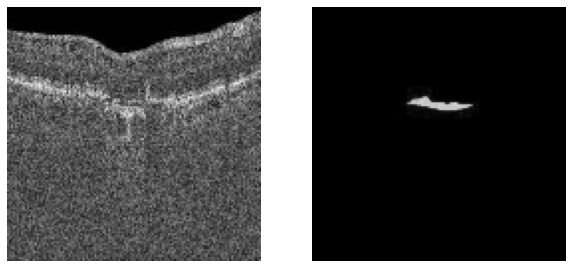

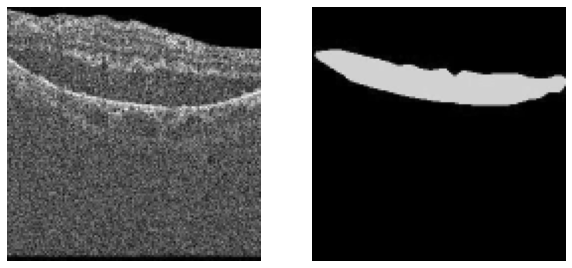

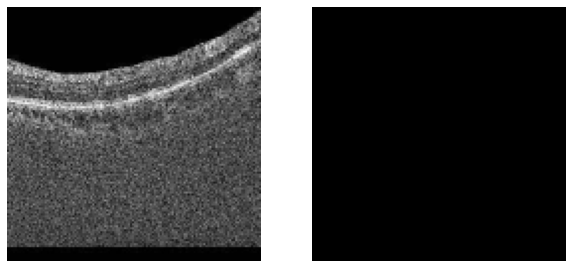

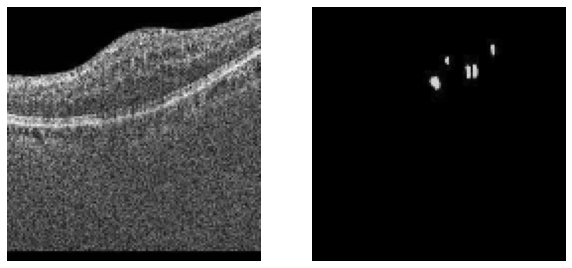

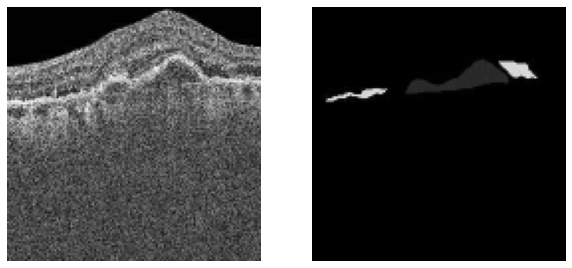

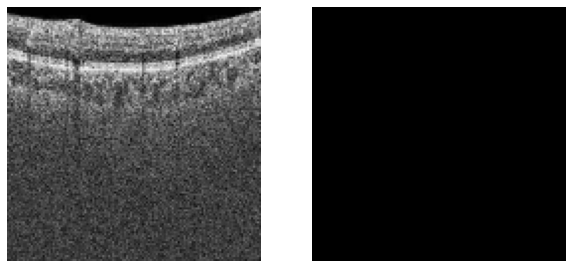

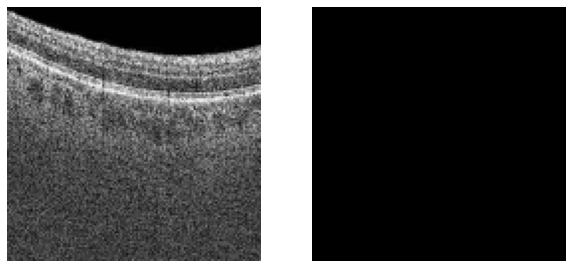

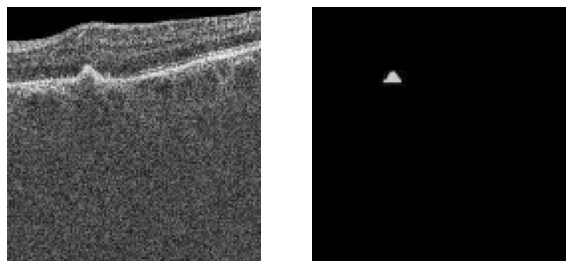

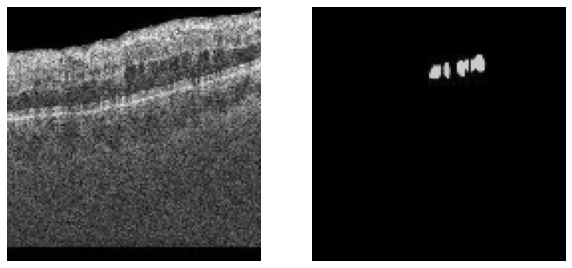

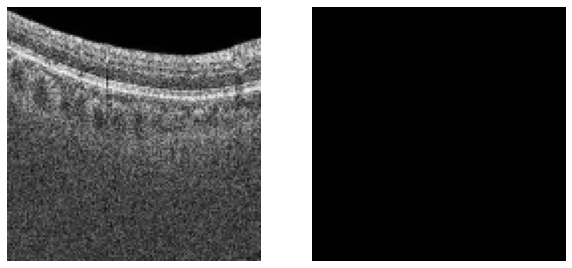

In [ ]:
# Visualize  sample data from training set with corresponding ground-truth labels.
for i in range(0, 500, 50):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_train[i].squeeze(), cmap='gray', vmin=0.0, vmax=1)
    ax[0].axis('off')
    ax[1].imshow(y_train[i].squeeze(), cmap='gray', vmin=0.0, vmax=1)
    ax[1].axis('off')

In [ ]:
# Define 2D convolutional block. Use He initialization and padding for convolutional layer with Relu activation.
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [ ]:
# Define UNET structure
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
# Define input shape and dropout rate. Compile the model with Adam optimizer and binary cross entropy cost function.
# Also apply batchnormalization to avoid vanishing gradient.
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=11, dropout=0.05, batchnorm=True)

# model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Print model summery
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 11  110         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 11  44         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [ ]:
# model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coef,'accuracy',tf.keras.metrics.Recall(),
                                                                     tf.keras.metrics.Precision()]) 

In [ ]:
# define early stop and reduce learning rate if loss does not change for 10 epochs
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [EarlyStopping(patience=10, verbose=1),
             ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0001, verbose=1),
             ModelCheckpoint('model_oct_edema.h5', verbose=1, save_best_only=True,save_weights_only=True)]

In [ ]:
# Train the model with back size of 50 for 30 epochs with early stop.
results = model.fit(X_train, y_train, batch_size=50, epochs=100, verbose=2, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.54995, saving model to model_oct_edema.h5
27/27 - 25s - loss: 0.3927 - dice_coef: 0.0166 - accuracy: 0.9499 - recall: 0.1563 - precision: 0.0409 - val_loss: 0.5500 - val_dice_coef: 0.0127 - val_accuracy: 0.9890 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010 - 25s/epoch - 910ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.54995 to 0.25040, saving model to model_oct_edema.h5
27/27 - 7s - loss: 0.2722 - dice_coef: 0.0215 - accuracy: 0.9893 - recall: 0.1170 - precision: 0.6828 - val_loss: 0.2504 - val_dice_coef: 0.0129 - val_accuracy: 0.9891 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010 - 7s/epoch - 262ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.25040 to 0.13918, saving model to model_oct_edema.h5
27/27 - 7s - loss: 0.2150 - dice_coef: 0.0301 - accuracy: 0.9900 - recall: 0.2973 - precision: 0.7879 - val_loss: 0.1392 - val_dice_coef: 0.0159 - val_accuracy: 0.9891 - val_recall: 0.00

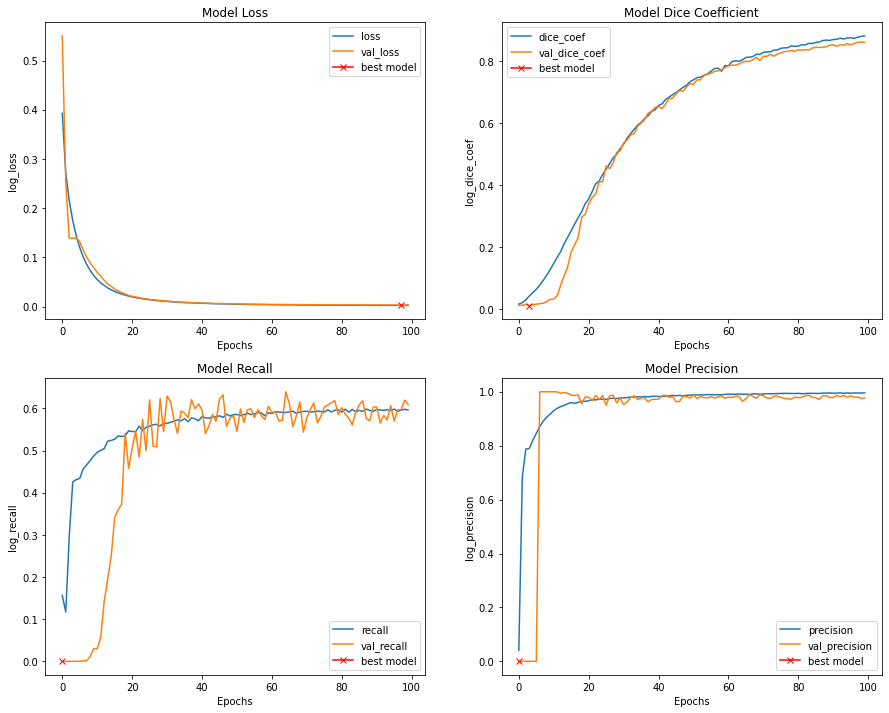

In [ ]:
f = plt.figure(figsize=(15,12))
plt.subplot(2, 2, 1 )
#plt.figure(figsize=(4,4))
plt.title("Model Loss")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]),
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.subplot(2, 2, 2)
#plt.figure(figsize=(6,6))
plt.title("Model Dice Coefficient")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot(np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]),
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_dice_coef")
plt.legend();

plt.subplot(2, 2, 3)
#plt.figure(figsize=(6,6))
plt.title("Model Recall")
plt.plot(results.history["recall"], label="recall")
plt.plot(results.history["val_recall"], label="val_recall")
plt.plot(np.argmin(results.history["val_recall"]), np.min(results.history["val_recall"]),
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_recall")
plt.legend();

plt.subplot(2, 2, 4)
#plt.figure(figsize=(6,6))
plt.title("Model Precision")
plt.plot(results.history["precision"], label="precision")
plt.plot(results.history["val_precision"], label="val_precision")
plt.plot(np.argmin(results.history["val_precision"]), np.min(results.history["val_precision"]),
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_precision")
plt.legend();

In [ ]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

5/5 [==============================] - 2s 52ms/step - loss: 0.0034 - dice_coef: 0.8570 - accuracy: 0.9923 - recall: 0.6092 - precision: 0.9769


[0.0034395158290863037,
 0.8569924235343933,
 0.9922558665275574,
 0.6091971397399902,
 0.9769107103347778]

In [ ]:
#Save weights
model.save_weights('weights.h5')

In [ ]:
# evaluate model on validation set
model.evaluate(X_valid, y_valid, batch_size=30, verbose=1)

5/5 [==============================] - 2s 52ms/step - loss: 0.0034 - dice_coef: 0.8570 - accuracy: 0.9923 - recall: 0.6092 - precision: 0.9769


[0.0034395158290863037,
 0.8569924235343933,
 0.9922558665275574,
 0.6091971397399902,
 0.9769107103347778]

In [ ]:
# Make prediction image
preds_val = model.predict(X_valid, verbose=0)

In [ ]:
# Threshold predictions to get binary label
preds_val_t = (preds_val > 0.6).astype(np.uint8)

In [ ]:
preds_val_t.shape

(308, 128, 128, 1)

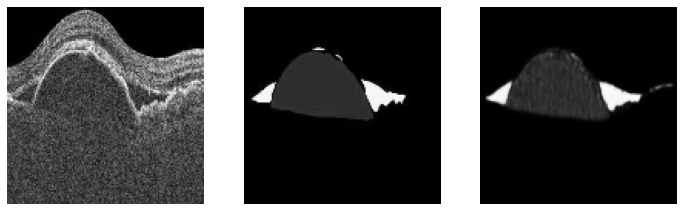

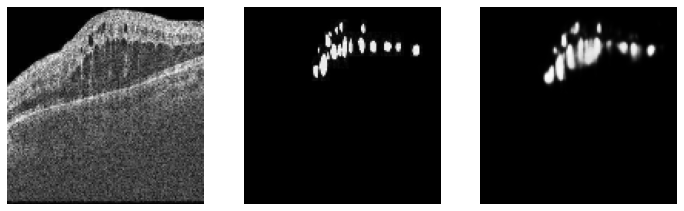

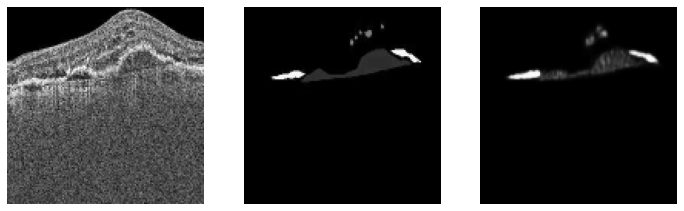

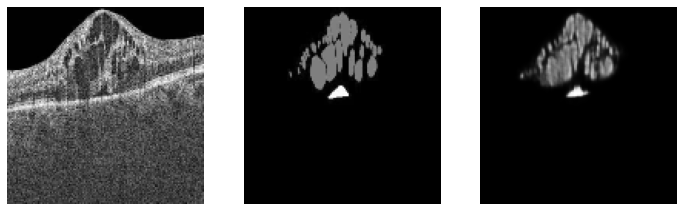

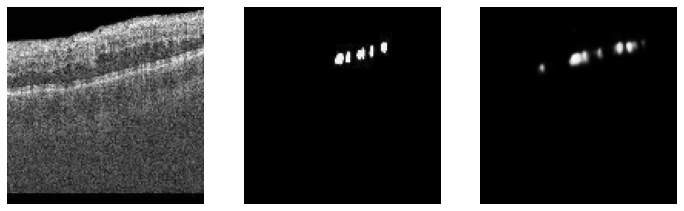

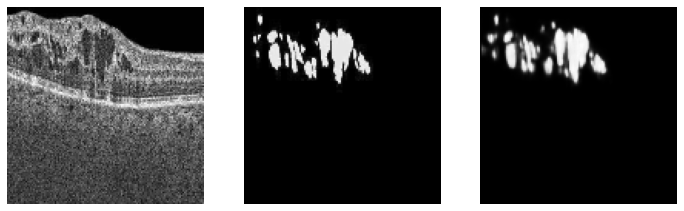

In [ ]:
# Visualize sample prediction from validation set(new cir3 data)             null
for idx in range(40, 53, 1):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].imshow(X_valid[idx].squeeze(), cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(y_valid[idx].squeeze(), cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(preds_val[idx].squeeze(), cmap='gray')
    ax[2].axis('off')